In [1]:
!date

Wed Mar  4 01:29:24 PST 2020


# Isoform atlas

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

cluster_order = [
    "L5 IT",
    "L5/6 NP",
    "L5 PT", 
    "L2/3 IT",
    "L6b",
    "L6 IT",
    "L6 CT",
    "L6 IT Car3",
    "Lamp5",
    "Sncg",
    "Vip",
    "Sst",
    "Pvalb",
    "VLMC",
    "Endo",
    "Astro",
    "SMC"
]

In [3]:
gene = anndata.read_h5ad("../cell_ranger_annotation/gene.h5ad")
isoform = anndata.read_h5ad("../cell_ranger_annotation/isoform.h5ad")

In [125]:
mfish = anndata.read_h5ad("../cell_ranger_annotation/merfish.h5ad")

Transforming to str index.


In [170]:
iso_markers = pd.read_csv("tables/subclass_DE_isoform_only.csv", index_col=0)
gene_markers = pd.read_csv("tables/merfish_DE.csv", index_col=0)

In [171]:
iso_markers

,index,transcript_name,p_raw,p_bonferroni,mean_log1p,mean_norm
0,Astro,AC130815.2-201_ENSMUST00000232175,9.268318e-13,3.205540e-08,0.506022,0.936217
1,Astro,Mc1r-201_ENSMUST00000098324,4.275874e-12,1.478854e-07,0.407544,0.642117
2,Endo,Icam2-201_ENSMUST00000001055,0.000000e+00,0.000000e+00,0.008268,0.840386
3,Endo,Egfl7-202_ENSMUST00000102907,0.000000e+00,0.000000e+00,0.011305,0.797767
4,Endo,Flt1-203_ENSMUST00000110529,0.000000e+00,0.000000e+00,0.061073,0.192482
...,...,...,...,...,...,...
2475,Vip,Rpl31-205_ENSMUST00000194746,1.214531e-09,4.200575e-05,3.383611,48.973915
2476,Vip,Rps3-201_ENSMUST00000032998,4.000519e-09,1.383620e-04,5.157430,185.039515
2477,Vip,Pfdn2-203_ENSMUST00000138323,1.276172e-08,4.413769e-04,3.937613,68.522820
2478,Vip,Rps23-201_ENSMUST00000051955,1.650026e-07,5.706782e-03,4.590950,111.648699


In [172]:
unique_map = {
"L5_IT" : "L5 IT",
"L6_CT" : "L6 CT",
"L6b" : "L6b",
"Vip" : "Vip",
"Pvalb" : "Pvalb",
"L2/3_IT" : "L2/3 IT",
"L6_IT" : "L6 IT",
"Sst" : "Sst",
"Lamp5" : "Lamp5",
"L56_NP" : "L5/6 NP",
"Sncg" : "Sncg",
"SMC" : "SMC",
"L5_PT" : "L5 PT", # Check
"Endothelial" : "Endo",
"Astrocytes" : "Astro",
"VLMC" : "VLMC",
"L6_IT_Car3" : "L6 IT Car3"}

inv_map = {v: k for k, v in unique_map.items()}

In [173]:
gene_markers["index"] = gene_markers["index"].apply(lambda x: unique_map.get(x, x))

# Find the genes that have differential isoforms based off of SMART-Seq data

In [174]:
iso_markers.index = iso_markers["index"].values
iso_markers["gene_name"] = iso_markers["transcript_name"].apply(lambda x: "".join(x.split("-")[:-1]))
gene_markers.index = gene_markers["index"].values

In [175]:
s1 = iso_markers["gene_name"]
s2 = gene_markers["gene_name"]

In [176]:
set1 = s1.index + "_" + s1.values
set2 = s2.index + "_" + s2.values

In [177]:
inter = pd.Series(list(set(set1).intersection(set(set2))))

In [178]:
subclasses = inter.apply(lambda x: x.split("_")[0])
genes =inter.apply(lambda x: x.split("_")[1])

In [179]:
np.sort((subclasses + "_" + genes).unique())

array(['Endo_Cldn5', 'Endo_Flt1', 'L2/3 IT_Lamp5', 'L2/3 IT_Unc5d',
       'L5 IT_St6galnac5', 'L5 PT_Fam84b', 'L5 PT_Iqgap2', 'L5 PT_Kcng1',
       'L5/6 NP_Tshz2', 'L6 IT Car3_Nr4a2', 'L6 IT Car3_Oprk1',
       'L6 IT_Epha7', 'L6 IT_Ptprt', 'L6 IT_Ptpru', 'Lamp5_Ptprm',
       'Pvalb_Pvalb', 'Sncg_Cxcl14', 'Sncg_Egln3', 'Sncg_Npas1',
       'Sncg_Nr2f2', 'Sncg_Shisa9', 'Sst_Grin3a', 'Sst_Grm1', 'Sst_Sst',
       'Vip_Vip'], dtype=object)

In [117]:
iso_markers[iso_markers["gene_name"] == "Pvalb"]

,index,transcript_name,p_raw,p_bonferroni,mean_log1p,mean_norm,gene_name
Pvalb,Pvalb,Pvalb-201_ENSMUST00000005860,0.0,0.0,0.852783,229.171951,Pvalb


In [182]:
marker_map = {
    "L5 IT": "Pou3f3-201_ENSMUST00000054883",
    "L5/6 NP": "Spon1-201_ENSMUST00000046687",
    "L5 PT": "Bcl11b-201_ENSMUST00000066060",
    "L2/3 IT": "C1ql3-201_ENSMUST00000061545",
    "L6b": "Olfm3-201_ENSMUST00000051309",
    "L6 IT": "Syndig1-202_ENSMUST00000109935",
    "L6 CT": "Sema5a-201_ENSMUST00000067458",    
    "L6 IT Car3": "Nr4a2-201_ENSMUST00000028166",
    "Lamp5": "Lamp5-202_ENSMUST00000123436",
    "Sncg": "Cxcl14-201_ENSMUST00000021970",
    "Vip": "Vip-201_ENSMUST00000019906",
    "Sst": "Sst-201_ENSMUST00000004480",
    "Pvalb": "Pvalb-201_ENSMUST00000005860",
    "Endo": "Cldn5-201_ENSMUST00000043577"}



cluster_order = [
    "L5 IT",
    "L5/6 NP",
    "L5 PT", 
    "L2/3 IT",
    "L6b",
    "L6 IT",
    "L6 CT",
    "L6 IT Car3",
    "Lamp5",
    "Sncg",
    "Vip",
    "Sst",
    "Pvalb",
    "Endo"
]

unique_map = {
"L5_IT" : "L5 IT",
"L6_CT" : "L6 CT",
"L6b" : "L6b",
"Vip" : "Vip",
"Pvalb" : "Pvalb",
"L2/3_IT" : "L2/3 IT",
"L6_IT" : "L6 IT",
"Sst" : "Sst",
"Lamp5" : "Lamp5",
"L56_NP" : "L5/6 NP",
"Sncg" : "Sncg",
"SMC" : "SMC",
"L5_PT" : "L5 PT", # Check
"Endothelial" : "Endo",
"Astrocytes" : "Astro",
"VLMC" : "VLMC",
"L6_IT_Car3" : "L6 IT Car3"}

inv_map = {v: k for k, v in unique_map.items()}

In [183]:
mfish.obs["subclass"] = mfish.obs.subclass.apply(lambda x: unique_map.get(x, x))

In [184]:
mfish_genes = [i.split("-")[0] for i in list(marker_map.values())]

In [194]:
mat = mfish.layers["norm"]
obs = mfish.obs
var = mfish.var

In [195]:
#pick isoform with top TPM

In [201]:
top_idx = [np.where(mfish.var.index.values == i)[0][0] for i in mfish_genes]
top_iso_name = ["".join(i.split("_")[:-1]) for i in list(marker_map.values())]

In [202]:
mfish_genes

['Pou3f3',
 'Spon1',
 'Bcl11b',
 'C1ql3',
 'Olfm3',
 'Syndig1',
 'Sema5a',
 'Nr4a2',
 'Lamp5',
 'Cxcl14',
 'Vip',
 'Sst',
 'Pvalb',
 'Cldn5']

In [203]:
top_iso_name

['Pou3f3-201',
 'Spon1-201',
 'Bcl11b-201',
 'C1ql3-201',
 'Olfm3-201',
 'Syndig1-202',
 'Sema5a-201',
 'Nr4a2-201',
 'Lamp5-202',
 'Cxcl14-201',
 'Vip-201',
 'Sst-201',
 'Pvalb-201',
 'Cldn5-201']

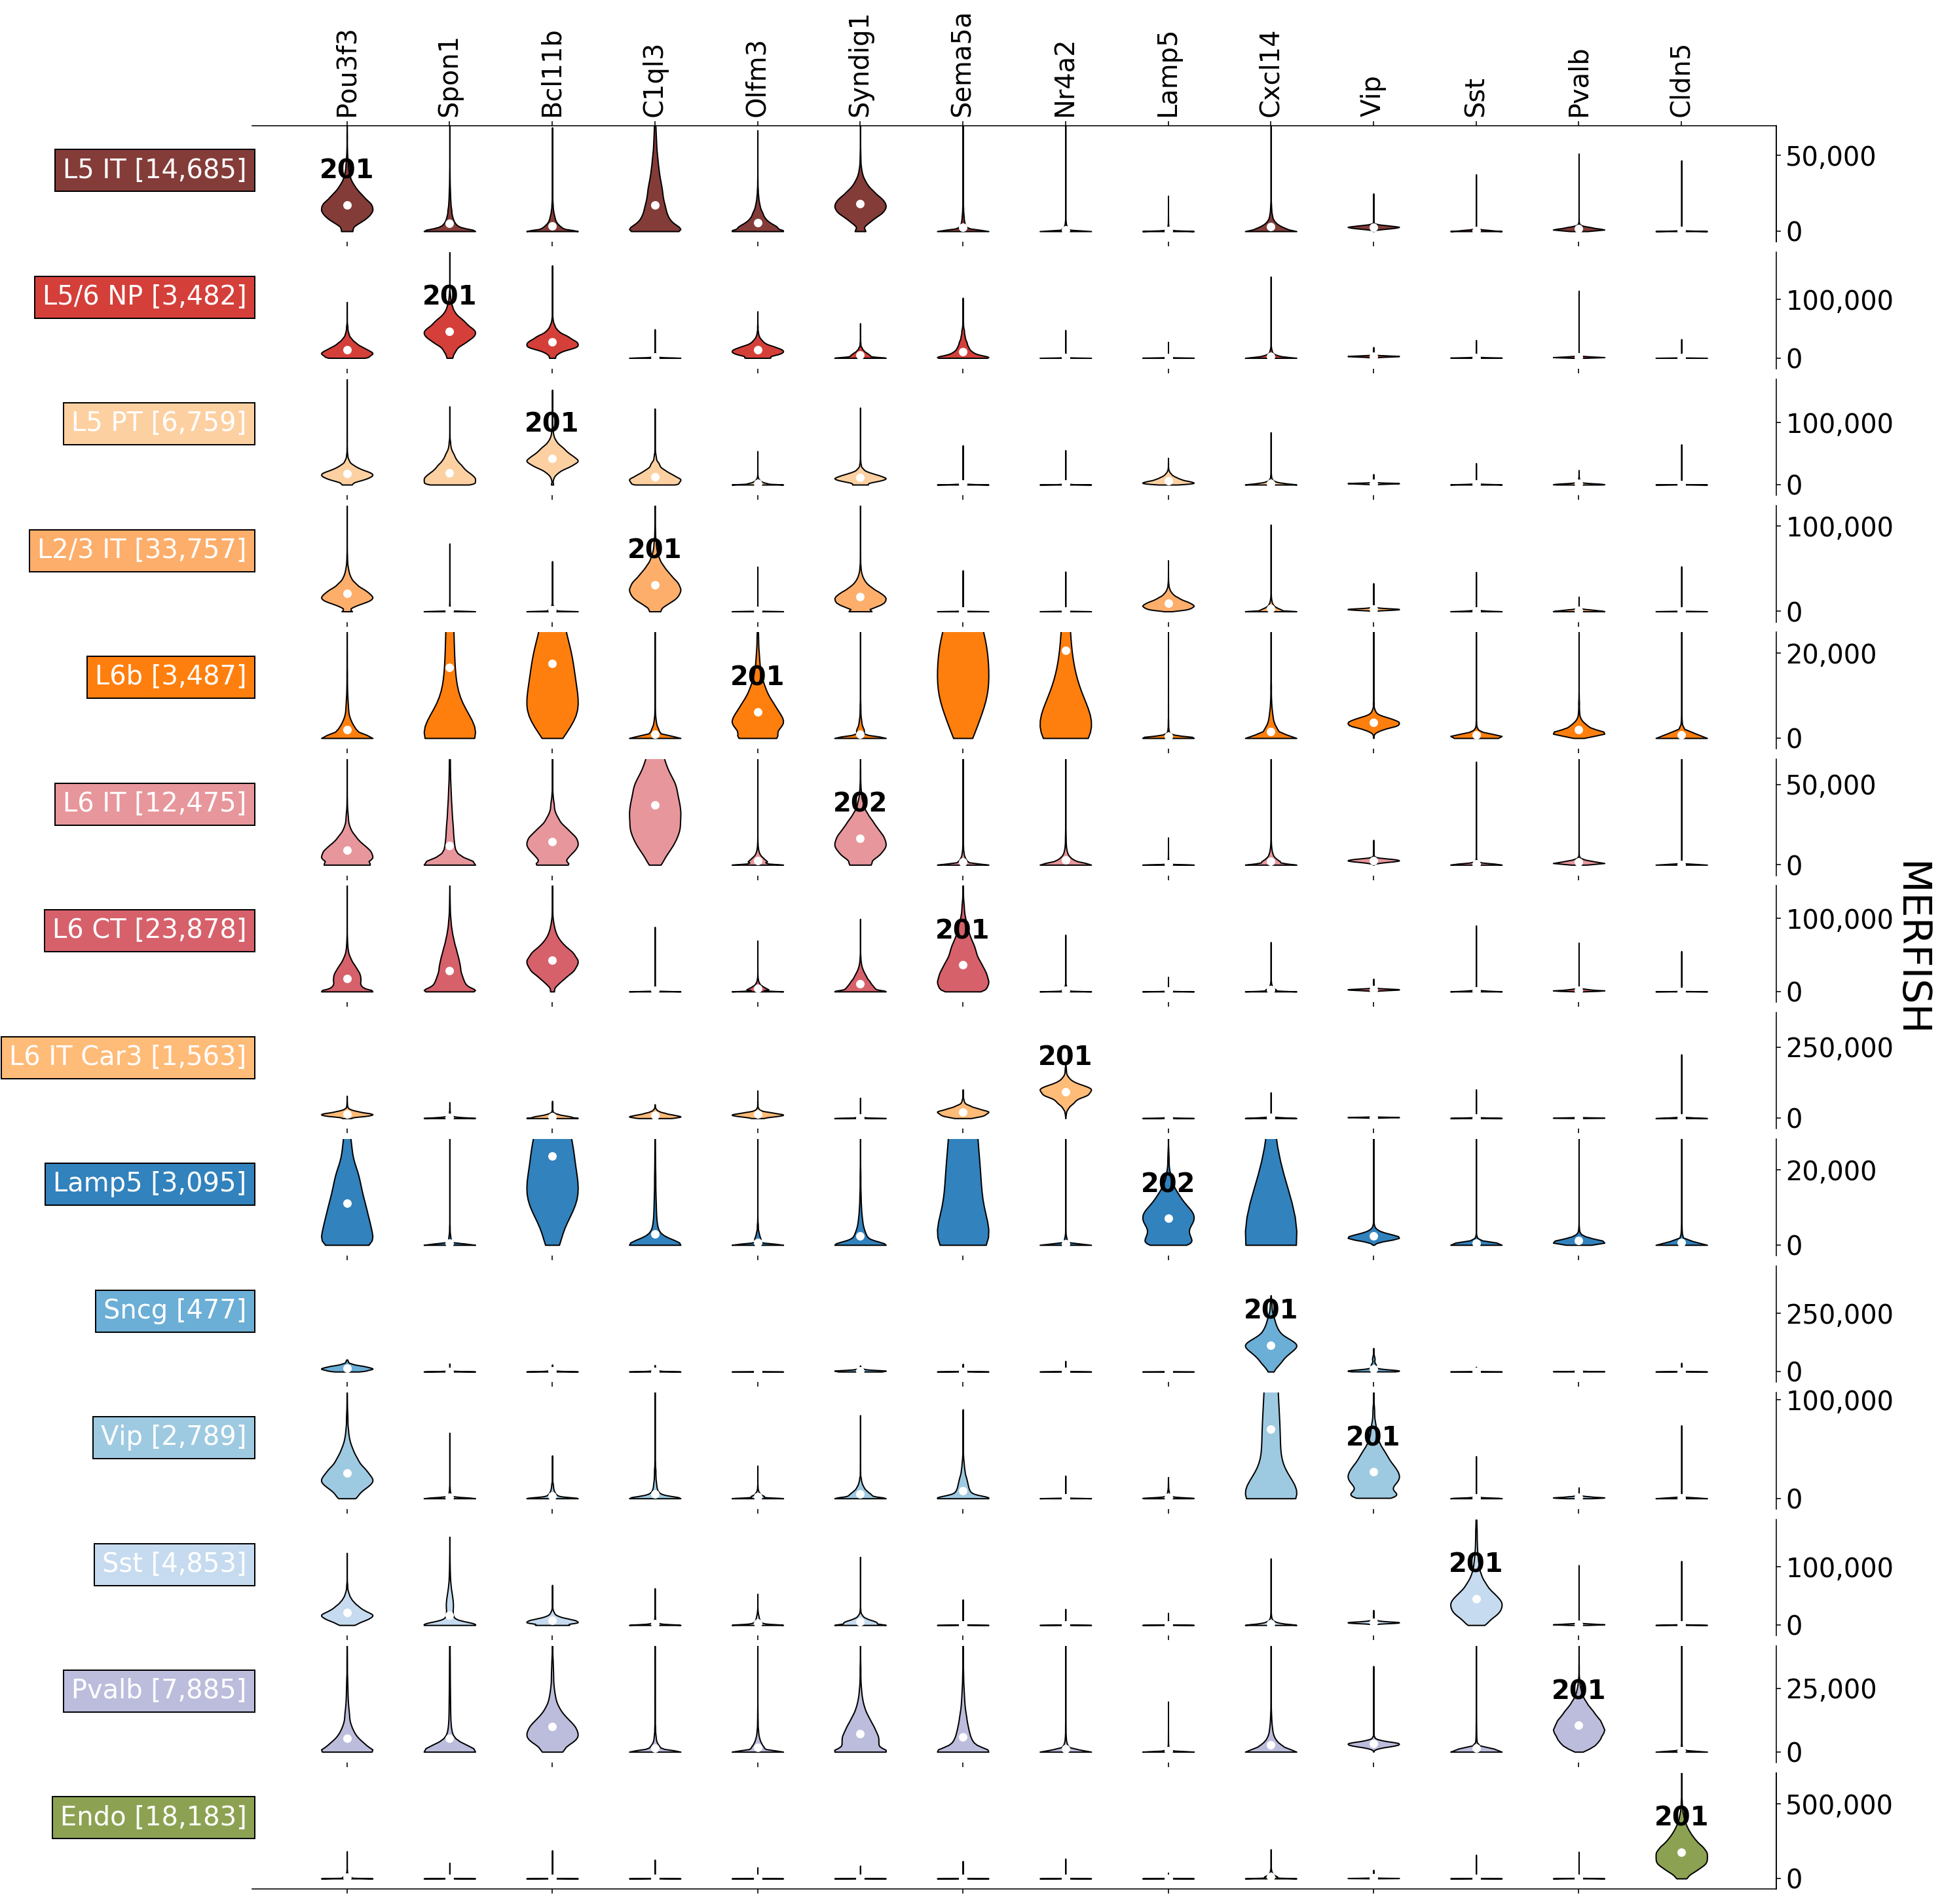

In [213]:
# unique = np.unique(gene.obs.subclass_label)
# unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.array(cluster_order)

fig, axs = plt.subplots(figsize=(20,20), nrows=len(unique))
fig.subplots_adjust(wspace=0, hspace=0)


labels = mfish_genes
lidx = np.arange(0, len(top_idx), 1)
means = []

for cidx, (c, ax) in enumerate(zip(unique, axs)):
    tmp_mat = mat[obs.subclass==c,:]
    
    x = tmp_mat[:,top_idx]
    means.append(nd(np.median(x,axis=0)))

    v = ax.violinplot(x.T.tolist(), showmedians=False, showextrema=False, positions=lidx)

    for pcidx, pc in enumerate(v['bodies']):
        pc.set_facecolor(cluster_cmap[c])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        #pc.set_facecolor('#D43F3A')
        

    means = [np.mean(i) for i in x.T]
    ax.scatter(lidx, means, marker='o', color='white', s=30, zorder=3)
     
    ax.annotate(top_iso_name[cidx].split("-")[-1], xy=(lidx[cidx], means[cidx]+means[cidx]), ha="center", weight="bold")

    if cidx==0:
        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(lidx)
        ax_top.set_xticklabels(labels, rotation=90, ha="center")
        ax_top.spines["top"].set_visible(True)
        ax_top.spines["left"].set_visible(False)
        ax_top.spines["bottom"].set_visible(False)
    if cidx == len(unique)-1:
        ax_bot = ax.twiny()
        ax_bot.set_xticks([])
        ax_bot.set_xticklabels([])
        ax_bot.spines["top"].set_visible(False)
        ax_bot.spines["left"].set_visible(False)
        ax_bot.spines["bottom"].set_visible(True)

    ax.set_xticklabels("")
    ax.yaxis.tick_right()
    ax.set_ylabel("{} [{:,}]".format(c, x.shape[0]), color="white",rotation="horizontal", ha="right",bbox=dict(boxstyle="square",ec="black",fc=cluster_cmap[c]))
    

    
    lim = nd(x.mean(axis=0))[cidx]*4
    
    ax.set_ylim(-lim*0.1, lim)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

        
    
    

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.text(1.01, 0.5, 'MERFISH ', ha='center', va='center', rotation=270, fontsize=30)
plt.savefig("./figures/spatial_isoform_atlas.png", bbox_inches='tight', dpi=300)
plt.show()